In [36]:
from src.data_utils import load_xsum_dict, load_shuffled_test_split

xsum_test = load_xsum_dict("test")
bart_test_extrinsic = load_shuffled_test_split(xsum_test, "bart-test-extrinsic", len(xsum_test))
print(
    len(bart_test_extrinsic),
    len(bart_test_extrinsic) / len(xsum_test)
)
pegasus_test_extrinsic = load_shuffled_test_split(xsum_test, "pegasus-test-extrinsic", len(xsum_test))
print(
    len(pegasus_test_extrinsic),
    len(pegasus_test_extrinsic) / len(xsum_test)
)

Using custom data configuration default
Reusing dataset xsum (/Users/anton164/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

6823 0.6019940003529204
6988 0.6165519675313217


In [50]:
import pandas as pd
import json

ent_type_map = {
    "DATE": "Date",
    "PERSON": "Person",
    "PERSON": "Person",
    "GPE": "Location",
    "LOC": "Location",
    "CARDINAL": "Numeric",
    "MONEY": "Numeric",
    "ORDINAL": "Numeric",
    "FAC": "FAC",
    "ORG": "ORG"
}

def map_entity_type(ent_type):
    if ent_type in ent_type_map:
        return ent_type_map[ent_type]
    else:
        return ent_type


def read_logs(path):
    with open(
        path,
        "r"
    ) as f:
        iteration_logs = json.load(f)

    data = []
    for iteration in iteration_logs:
        for ent_type in iteration["factuality_entities"]["type"].keys():
            ent_stats = iteration["factuality_entities"]["type"][ent_type]
            result_obj = {
                "iteration": iteration["iteration"],
                "entity_type": ent_type,
                "total": ent_stats["total"],
                "extrinsic_factual": ent_stats["Factual Hallucination"] if "Factual Hallucination" in ent_stats else 0,
                "extrinsic_non_factual": ent_stats["Non-factual Hallucination"] if "Non-factual Hallucination" in ent_stats else 0,
                "intrinsic_factual": ent_stats["Non-hallucinated"] if "Non-hallucinated" in ent_stats else 0,
                "intrinsic_non_factual": ent_stats["Intrinsic Hallucination"] if "Intrinsic Hallucination" in ent_stats else 0,
                "unknown": ent_stats["Unknown"] if "Unknown" in ent_stats else 0,
            }
            data.append(result_obj)
    
    df = pd.DataFrame(data).set_index("iteration")
    df["annotated"] = df["total"] - df["unknown"]
    return df, iteration_logs

dataset = "bart-test-extrinsic-200"
df_clf, logs_clf = read_logs(
    f"results/iteration-changes/{dataset}-classifier-knnv2.json"
)

df_clf

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,CARDINAL,38,12,11,12,3,0,38
0,DATE,75,20,37,17,1,0,75
0,EVENT,16,10,0,5,1,0,16
0,FAC,10,5,1,3,1,0,10
0,GPE,155,33,21,93,8,0,155
...,...,...,...,...,...,...,...,...
12,PERCENT,4,1,0,2,1,0,4
12,PERSON,210,48,31,121,10,0,210
12,PRODUCT,2,0,0,1,1,0,2


In [51]:
df_clf.loc[0].annotated.sum()

726

In [53]:
df_clf.loc[0].sort_values("extrinsic_non_factual", ascending=False)

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,DATE,75,20,37,17,1,0,75
0,PERSON,219,56,34,124,5,0,219
0,GPE,155,33,21,93,8,0,155
0,CARDINAL,38,12,11,12,3,0,38
0,ORG,128,43,9,71,5,0,128
0,LOC,7,1,5,1,0,0,7
0,MONEY,9,3,5,1,0,0,9
0,ORDINAL,18,6,5,6,1,0,18
0,PRODUCT,4,0,2,1,1,0,4


In [54]:
df_clf[df_clf.entity_type == "PERSON"]

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,PERSON,219,56,34,124,5,0,219
1,PERSON,217,49,30,108,11,19,198
2,PERSON,213,49,30,113,10,11,202
3,PERSON,208,48,29,115,10,6,202
4,PERSON,212,48,30,120,10,4,208
5,PERSON,210,48,31,121,10,0,210
6,PERSON,210,48,31,121,10,0,210
7,PERSON,210,48,31,121,10,0,210
8,PERSON,210,48,31,121,10,0,210


In [55]:
df_clf[df_clf.entity_type == "GPE"]

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,GPE,155,33,21,93,8,0,155
1,GPE,159,33,19,91,6,10,149
2,GPE,161,33,19,95,7,7,154
3,GPE,166,35,16,96,7,12,154
4,GPE,163,34,18,99,7,5,158
5,GPE,161,35,19,99,7,1,160
6,GPE,164,34,19,99,8,4,160
7,GPE,164,35,19,100,8,2,162
8,GPE,164,35,19,100,8,2,162


In [56]:
df_clf[df_clf.entity_type == "ORG"]

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,ORG,128,43,9,71,5,0,128
1,ORG,124,38,8,65,5,8,116
2,ORG,132,37,8,69,6,12,120
3,ORG,130,38,11,72,6,3,127
4,ORG,127,38,10,72,6,1,126
5,ORG,130,38,12,73,6,1,129
6,ORG,128,38,11,73,6,0,128
7,ORG,129,38,11,73,6,1,128
8,ORG,129,38,11,73,6,1,128


In [57]:
df_plot = df_clf[
    df_clf.entity_type.isin(["PERSON", "GPE", "ORG", "DATE", "CARDINAL"])
    & df_clf.index.isin([0, max(df_clf.index)])
]
df_plot.loc[:, "Model"] = "Baseline"
df_plot.loc[max(df_clf.index), "Model"] = "GEF"
df_plot.loc[:, "extrinsic_factual_ratio"] = df_plot["extrinsic_factual"] / (
    df_plot["extrinsic_factual"] + df_plot["extrinsic_non_factual"]
)
df_plot.loc[:, "factual_ratio"] = (df_plot["extrinsic_factual"] + df_plot["intrinsic_factual"]) / (
    df_plot["total"]
)
df_plot

/var/folders/yb/l4pdzll51k946vtlt23kftkh0000gn/T/ipykernel_36617/1707997999.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.loc[:, "Model"] = "Baseline"
/var/folders/yb/l4pdzll51k946vtlt23kftkh0000gn/T/ipykernel_36617/1707997999.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.loc[:, "extrinsic_factual_ratio"] = df_plot["extrinsic_factual"] / (
/var/folders/yb/l4pdzll51k946vtlt23kftkh0000gn/T/ipykernel_36617/1707997999.py:10: SettingWithCopyWarning: 
A value is trying to be set on a c

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated,Model,extrinsic_factual_ratio,factual_ratio
iteration,,,,,,,,,,,
0,CARDINAL,38,12,11,12,3,0,38,Baseline,0.521739,0.631579
0,DATE,75,20,37,17,1,0,75,Baseline,0.350877,0.493333
0,GPE,155,33,21,93,8,0,155,Baseline,0.611111,0.812903
0,ORG,128,43,9,71,5,0,128,Baseline,0.826923,0.890625
0,PERSON,219,56,34,124,5,0,219,Baseline,0.622222,0.821918
12,CARDINAL,42,14,11,12,5,0,42,GEF,0.560000,0.619048
12,DATE,62,15,20,24,3,0,62,GEF,0.428571,0.629032
12,GPE,164,35,21,100,8,0,164,GEF,0.625000,0.823171
12,ORG,128,38,11,73,6,0,128,GEF,0.775510,0.867188


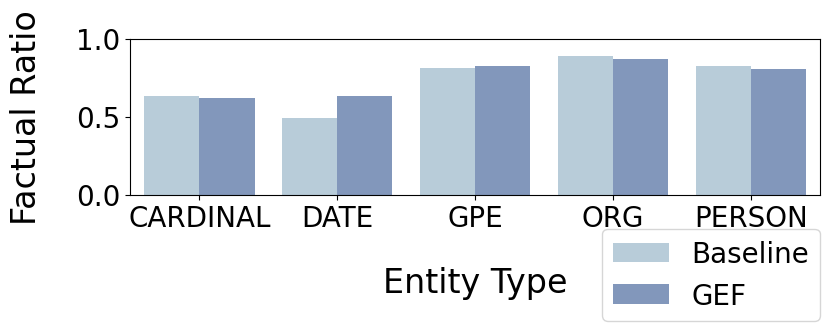

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt


fg = sns.catplot(
    x="entity_type", 
    y="factual_ratio", 
    hue="Model",
    kind="bar",
    data=df_plot,
    legend=False,
    height=3.5,
    palette=["#B3CDDE", "#7895C4"],
    aspect=2.4,
    ci=None
)
FONT_SIZE = 20
fg.ax.set_xlabel("Entity Type", fontsize=24, labelpad=24)
fg.ax.set_ylabel("Factual Ratio", fontsize=24, labelpad=24)
plt.setp(fg.ax.patches, linewidth=0.5)
fg.ax.yaxis.set_ticks([0, 0.5, 1])
sns.despine(bottom = False, left = False, top=False, right=False)
plt.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
plt.legend(bbox_to_anchor=(1, -0.22), loc='upper right', borderaxespad=0, prop={'size': 20}, ncol=1)
# plt.legend()
plt.tight_layout()
plt.savefig("plots/entity_types.pdf")
# ax

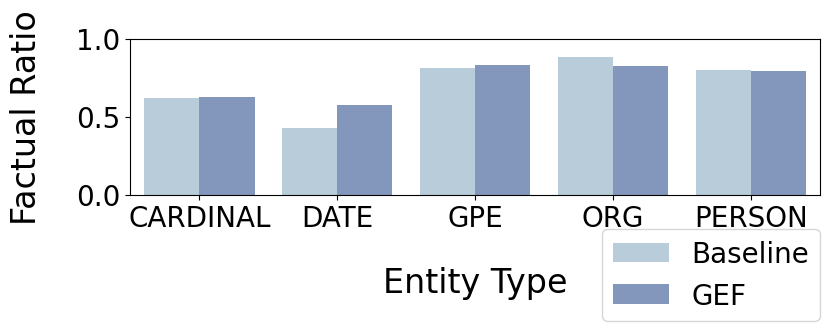

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt


fg = sns.catplot(
    x="entity_type", 
    y="factual_ratio", 
    hue="Model",
    kind="bar",
    data=df_plot,
    legend=False,
    height=3.5,
    palette=["#B3CDDE", "#7895C4"],
    aspect=2.4,
    ci=None
)
FONT_SIZE = 20
fg.ax.set_xlabel("Entity Type", fontsize=24, labelpad=24)
fg.ax.set_ylabel("Factual Ratio", fontsize=24, labelpad=24)
plt.setp(fg.ax.patches, linewidth=0.5)
fg.ax.yaxis.set_ticks([0, 0.5, 1])
sns.despine(bottom = False, left = False, top=False, right=False)
plt.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
plt.legend(bbox_to_anchor=(1, -0.22), loc='upper right', borderaxespad=0, prop={'size': 20}, ncol=1)
# plt.legend()
plt.tight_layout()
plt.savefig("plots/entity_types.pdf")
# ax

In [46]:
import pandas as pd
import json

ent_type_map = {
    "DATE": "Date",
    "PERSON": "Person",
    "PERSON": "Person",
    "GPE": "Location",
    "LOC": "Location",
    "CARDINAL": "Numeric",
    "MONEY": "Numeric",
    "ORDINAL": "Numeric",
    "FAC": "FAC",
    "ORG": "ORG"
}

def map_entity_type(ent_type):
    if ent_type in ent_type_map:
        return ent_type_map[ent_type]
    else:
        return ent_type


def read_logs(path):
    with open(
        path,
        "r"
    ) as f:
        iteration_logs = json.load(f)

    data = []
    for iteration in iteration_logs:
        for ent_type in iteration["factuality_entities"]["type"].keys():
            ent_stats = iteration["factuality_entities"]["type"][ent_type]
            result_obj = {
                "iteration": iteration["iteration"],
                "entity_type": ent_type,
                "total": ent_stats["total"],
                "extrinsic_factual": ent_stats["Factual Hallucination"] if "Factual Hallucination" in ent_stats else 0,
                "extrinsic_non_factual": ent_stats["Non-factual Hallucination"] if "Non-factual Hallucination" in ent_stats else 0,
                "intrinsic_factual": ent_stats["Non-hallucinated"] if "Non-hallucinated" in ent_stats else 0,
                "intrinsic_non_factual": ent_stats["Intrinsic Hallucination"] if "Intrinsic Hallucination" in ent_stats else 0,
                "unknown": ent_stats["Unknown"] if "Unknown" in ent_stats else 0,
            }
            data.append(result_obj)
    
    df = pd.DataFrame(data).set_index("iteration")
    df["annotated"] = df["total"] - df["unknown"]
    return df, iteration_logs

df_clf, logs_clf = read_logs(
    f"results/iteration-changes/bart-full-classifier-knnv1.json"
)

df_clf

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,CARDINAL,2324,15,20,42,7,2240,84
0,DATE,3298,28,49,32,3,3186,112
0,EVENT,698,7,1,7,1,682,16
0,FAC,363,5,2,7,1,348,15
0,GPE,8064,60,28,253,4,7719,345
...,...,...,...,...,...,...,...,...
12,PERSON,10067,98,33,311,11,9614,453
12,PRODUCT,138,0,0,4,0,134,4
12,QUANTITY,26,0,0,0,0,26,0


In [47]:
df_clf.loc[0].sort_values("total", ascending=False)

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,PERSON,10160,117,50,350,8,9635,525
0,GPE,8064,60,28,253,4,7719,345
0,ORG,5685,69,11,136,3,5466,219
0,DATE,3298,28,49,32,3,3186,112
0,CARDINAL,2324,15,20,42,7,2240,84
0,NORP,1972,13,3,79,3,1874,98
0,ORDINAL,938,6,7,12,2,911,27
0,EVENT,698,7,1,7,1,682,16
0,LOC,464,0,4,9,0,451,13


In [48]:
df_plot = df_clf[
    df_clf.entity_type.isin(["PERSON", "GPE", "ORG", "DATE", "CARDINAL"])
    & df_clf.index.isin([0, max(df_clf.index)])
]
df_plot.loc[:, "Model"] = "Baseline"
df_plot.loc[max(df_clf.index), "Model"] = "GEF"
df_plot.loc[:, "extrinsic_factual_ratio"] = df_plot["extrinsic_factual"] / (
    df_plot["extrinsic_factual"] + df_plot["extrinsic_non_factual"]
)
df_plot.loc[:, "factual_ratio"] = (df_plot["extrinsic_factual"] + df_plot["intrinsic_factual"]) / (
    df_plot["total"]
)
df_plot.loc[:, "per_sum"] = df_plot["total"] / 11334
df_plot

/var/folders/yb/l4pdzll51k946vtlt23kftkh0000gn/T/ipykernel_36617/1587372597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.loc[:, "Model"] = "Baseline"
/var/folders/yb/l4pdzll51k946vtlt23kftkh0000gn/T/ipykernel_36617/1587372597.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.loc[:, "extrinsic_factual_ratio"] = df_plot["extrinsic_factual"] / (
/var/folders/yb/l4pdzll51k946vtlt23kftkh0000gn/T/ipykernel_36617/1587372597.py:10: SettingWithCopyWarning: 
A value is trying to be set on a c

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated,Model,extrinsic_factual_ratio,factual_ratio,per_sum
iteration,,,,,,,,,,,,
0,CARDINAL,2324,15,20,42,7,2240,84,Baseline,0.428571,0.024527,0.205047
0,DATE,3298,28,49,32,3,3186,112,Baseline,0.363636,0.018193,0.290983
0,GPE,8064,60,28,253,4,7719,345,Baseline,0.681818,0.038814,0.711488
0,ORG,5685,69,11,136,3,5466,219,Baseline,0.862500,0.036060,0.501588
0,PERSON,10160,117,50,350,8,9635,525,Baseline,0.700599,0.045965,0.896418
12,CARDINAL,2399,12,16,43,7,2321,78,GEF,0.428571,0.022926,0.211664
12,DATE,2854,22,20,29,4,2779,75,GEF,0.523810,0.017870,0.251809
12,GPE,8056,52,16,240,4,7744,312,GEF,0.764706,0.036246,0.710782
12,ORG,5645,57,12,131,2,5443,202,GEF,0.826087,0.033304,0.498059


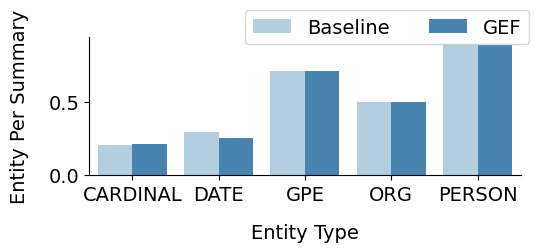

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt


fg = sns.catplot(
    x="entity_type", 
    y="per_sum", 
    hue="Model",
    kind="bar",
    data=df_plot,
    legend=False,
    height=2.75,
    palette="Blues",
    aspect=2,
    ci=None
)
FONT_SIZE = 14
fg.ax.set_xlabel("Entity Type", fontsize=FONT_SIZE, labelpad=FONT_SIZE)
fg.ax.set_ylabel("Entity Per Summary", fontsize=FONT_SIZE, labelpad=FONT_SIZE)
plt.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
plt.legend(bbox_to_anchor=(1.02, 1.2), loc='upper right', borderaxespad=0, prop={'size': 14}, ncol=2)
plt.tight_layout()
plt.savefig("plots/entity_types_per_summary.pdf")
# ax